In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable

In [3]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
from PIL import Image

import time
torch.manual_seed(0);

__Load Dataset__

In [27]:
IMG_SIZE = 28 # Original = 28 

#Create a transform to resize images and convert to tensor
composed = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.ToTensor()])

#Load Train and Test Datasets
train_set = datasets.FashionMNIST(root='.fashion/data', train=True, download=True, transform=composed)
test_set  = datasets.FashionMNIST(root='.fashion/data', train=False, download=True, transform=composed)

In [5]:
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
    plt.title('y = ' + str(data_sample[1]))

## Question 1
Take a screen shot of  the first three images of the validation dataset  from the code provided . The function show_data

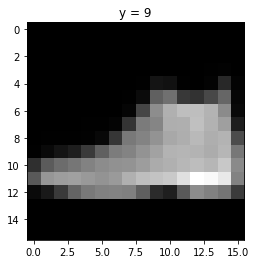

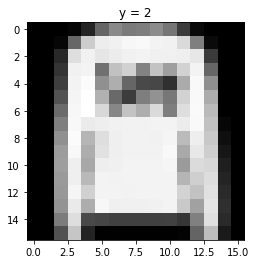

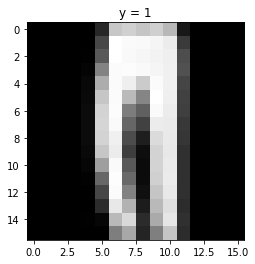

In [6]:
for n in range(3):
    show_data(test_set[n])
    plt.show()

__Building a CNN__

In [28]:
class FashionCNN(nn.Module):
    def __init__(self, Ndim ):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            # Input IMG_SIZE x IMG_SIZE x 1 -> Output IMG_SIZE x IMG_SIZE x Ndim 
            # 16 x 16 x 1 -> 16 x  16 x 32
            # 28 x 28  x 1 -> 28 x 28  x 32
            nn.Conv2d(in_channels=1, out_channels=Ndim, kernel_size=3, padding=1),
            nn.BatchNorm2d(Ndim),
            nn.ReLU(),
            # Input  IMG_SIZE x IMG_SIZE x Ndim  -> Output IMG_SIZE/2 x IMG_SIZE/2 x Ndim 
            # 28 x 28  x 32 -> 14 x 14 x 32
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            # IMG_SIZE/2 x IMG_SIZE/2 x Ndim  -> Output IMG_SIZE/2 x IMG_SIZE/2 x Ndim*2 
            # 14 x  14 x 32 -> 14 x  14 x 64
            nn.Conv2d(in_channels=Ndim, out_channels=Ndim*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(Ndim*2),
            nn.ReLU(),
            
            # IMG_SIZE/2 x IMG_SIZE/2 x Ndim*2  -> Output IMG_SIZE/4 x IMG_SIZE/4 x Ndim*2 
            # 14 x  14 x 64 -> 7 x  7 x 64                
            nn.MaxPool2d(2)
        )
        
        #self.fc1 = nn.Linear(in_features= Ndim*2 *4*4, out_features=10) 
        
        #self.bn_fc1 = nn.BatchNorm1d(10)
        self.fc1 = nn.Linear(in_features= Ndim*2 *7*7, out_features=512)   
        #self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=512, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10) 
        # self.bn_fc1 = nn.BatchNorm1d(10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        #out = self.fc1(out)
        #out = self.bn_fc1(out)
        out = self.fc1(out)
        #out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out        

In [29]:
model = FashionCNN(32)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100)

print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=3136, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [30]:
cost_list = []
accuracy_list = []
N_test = len(test_set)
n_epochs = 8

for epoch in range(n_epochs):
    
    print('Epoch :',epoch)
    cost = 0
    model.train()
    for x, y in train_loader:
        optimizer.zero_grad()
        z = model(x)
        loss = criterion(z, y)
        loss.backward()
        optimizer.step()
        cost += loss.item()
    correct = 0
    
    # Testing the model
    model.eval()
    for x_test, y_test in test_loader:
        z = model(x_test)
        _, yhat = torch.max(z.data, 1)
        correct += (yhat == y_test).sum().item()
    accuracy = correct / N_test
    accuracy_list.append(accuracy)
    cost_list.append(cost)
    print('accuracy {}  cost {} '.format(accuracy, cost))


Epoch : 0
accuracy 0.8573  cost 343.38104635477066 
Epoch : 1
accuracy 0.8766  cost 214.80540437996387 
Epoch : 2
accuracy 0.8889  cost 186.42772814631462 
Epoch : 3
accuracy 0.8954  cost 169.80957816541195 
Epoch : 4
accuracy 0.8991  cost 157.88846220076084 
Epoch : 5
accuracy 0.9012  cost 148.49779395014048 
Epoch : 6
accuracy 0.9034  cost 140.68851302564144 
Epoch : 7
accuracy 0.905  cost 133.94248165935278 


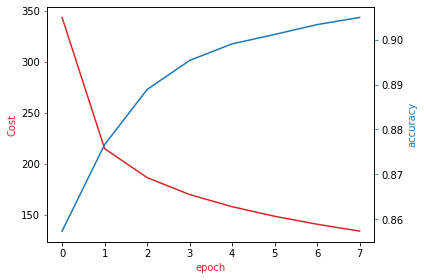

In [31]:
# Plot the loss and accuracy
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(cost_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)
ax2.set_xlabel('epoch', color=color)
ax2.plot(accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()